# Example Script for Monte Carlo and Importance 
The purpose of this notebook is to suplement my tutorial on Monte Carlo and importance sampling. Feel free to use and adapt any of these functions for your own numeric simulations.

In [1]:
import numpy as np
import math
import random
from matplotlib import pyplot as plt
from IPython.display import clear_output

PI = 3.1415926
e = 2.71828

## Baseline Functions

In [2]:
# let's define some helper functions for later

def get_rand_number(min_value, max_value):
    """
    This functions gets a random number from a uniform distribution between
    the two input values [min_value, max_value] inclusively
    Args:
    - min_value (float)
    - max_value (float)
    Return:
    - Random number between this range (float)
    """
    range = max_value - min_value
    choice = random.uniform(0,1)
    return min_value + range*choice

In [3]:
# lets also define the function we want to integrate over f(x)

def f_of_x(x):
    """
    This is the main function we want to integrate over.
    Args:
    - x (float) : input to function; must be in radians
    Return:
    - output of function f(x) (float)
    """
    return (e**(-1*x))/(1+(x-1)**2)

# Crude Monte Carlo

In [4]:
def crude_monte_carlo(num_samples=5000):
    """
    This function performs the Crude Monte Carlo for our
    specific function f(x) on the range x=0 to x=5.
    Notice that this bound is sufficient because f(x)
    approaches 0 at around PI.
    Args:
    - num_samples (float) : number of samples
    Return:
    - Crude Monte Carlo estimation (float)
    
    """
    lower_bound = 0
    upper_bound = 5
    
    sum_of_samples = 0
    for i in range(num_samples):
        x = get_rand_number(lower_bound, upper_bound)
        sum_of_samples += f_of_x(x)
    
    return (upper_bound - lower_bound) * float(sum_of_samples/num_samples)

In [5]:
def get_crude_MC_variance(num_samples):
    """
    This function returns the variance fo the Crude Monte Carlo.
    Note that the inputed number of samples does not neccissarily
    need to correspond to number of samples used in the Monte
    Carlo Simulation.
    Args:
    - num_samples (int)
    Return:
    - Variance for Crude Monte Carlo approximation of f(x) (float)
    """
    int_max = 5 # this is the max of our integration range
    
    # get the average of squares
    running_total = 0
    for i in range(num_samples):
        x = get_rand_number(0, int_max)
        running_total += f_of_x(x)**2
    sum_of_sqs = running_total*int_max / num_samples
    
    # get square of average
    running_total = 0
    for i in range(num_samples):
        x = get_rand_number(0, int_max)
        running_total = f_of_x(x)
    sq_ave = (int_max*running_total/num_samples)**2
    
    return sum_of_sqs - sq_ave

### Perform the Simulation

In [6]:
# Now we will run a Crude Monte Carlo simulation with 10000 samples
# We will also calculate the variance with 10000 samples and the error

MC_samples = 10000
var_samples = 10000 # number of samples we will use to calculate the variance
crude_estimation = crude_monte_carlo(MC_samples)
variance = get_crude_MC_variance(var_samples)
error = math.sqrt(variance/MC_samples)

# display results
print(f"Monte Carlo Approximation of f(x): {crude_estimation}")
print(f"Variance of Approximation: {variance}")
print(f"Error in Approximation: {error}")

Monte Carlo Approximation of f(x): 0.6825735870437116
Variance of Approximation: 0.2760043286191127
Error in Approximation: 0.005253611411392288


# Importance Sampling

### Determine Optimal Weight Function Template

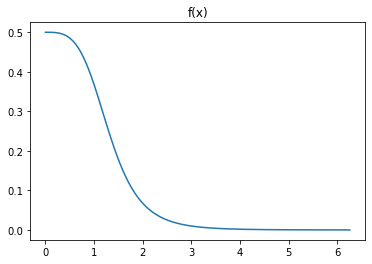

In [7]:
# plot the function
xs = [float(i/50) for i in range(int(50*PI*2))]
ys = [f_of_x(x) for x in xs]
plt.plot(xs,ys)
plt.title("f(x)");

In [8]:
# this is the template of our weight function g(x)
def g_of_x(x, A, lamda):
    e = 2.71828
    return A*math.pow(e, -1*lamda*x)

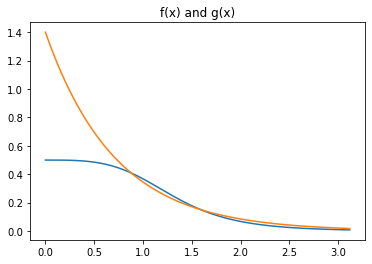

In [9]:
xs = [float(i/50) for i in range(int(50*PI))]
fs = [f_of_x(x) for x in xs]
gs = [g_of_x(x, A=1.4, lamda=1.4) for x in xs]
plt.plot(xs, fs)
plt.plot(xs, gs)
plt.title("f(x) and g(x)");

### Determine the Optimal Parameters for Our Weight Function

In [10]:
def inverse_G_of_r(r, lamda):
    return (-1 * math.log(float(r)))/lamda

In [11]:
def get_IS_variance(lamda, num_samples):
    """
    This function calculates the variance if a Monte Carlo
    using importance sampling.
    Args:
    - lamda (float) : lamdba value of g(x) being tested
    Return: 
    - Variance
    """
    A = lamda
    int_max = 5
    
    # get sum of squares
    running_total = 0
    for i in range(num_samples):
        x = get_rand_number(0, int_max)
        running_total += (f_of_x(x)/g_of_x(x, A, lamda))**2
    
    sum_of_sqs = running_total / num_samples
    
    # get squared average
    running_total = 0
    for i in range(num_samples):
        x = get_rand_number(0, int_max)
        running_total += f_of_x(x)/g_of_x(x, A, lamda)
    sq_ave = (running_total/num_samples)**2
    
    
    return sum_of_sqs - sq_ave

In [12]:
# get variance as a function of lambda by testing many
# different lambdas

test_lamdas = [i*0.05 for i in range(1, 61)]
variances = []

for i, lamda in enumerate(test_lamdas):
    print(f"lambda {i+1}/{len(test_lamdas)}: {lamda}")
    A = lamda
    variances.append(get_IS_variance(lamda, 10000))
    clear_output(wait=True)
    
optimal_lamda = test_lamdas[np.argmin(np.asarray(variances))]
IS_variance = variances[np.argmin(np.asarray(variances))]

print(f"Optimal Lambda: {optimal_lamda}")
print(f"Optimal Variance: {IS_variance}")
print((IS_variance/10000)**0.5)

Optimal Lambda: 1.6500000000000001
Optimal Variance: 0.047331706439842525
0.0021755851268070972


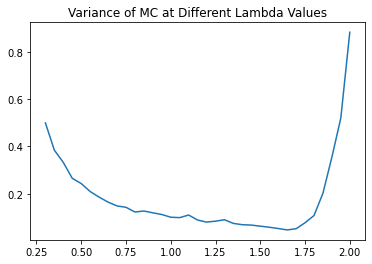

In [13]:
plt.plot(test_lamdas[5:40], variances[5:40])
plt.title("Variance of MC at Different Lambda Values");

### Perform Importance Sampling Monte Carlo with Optimized Weight Function

In [14]:
def importance_sampling_MC(lamda, num_samples):
    A = lamda
    
    running_total = 0
    for i in range(num_samples):
        r = get_rand_number(0,1)
        running_total += f_of_x(inverse_G_of_r(r, lamda=lamda))/g_of_x(inverse_G_of_r(r, lamda=lamda), A, lamda)
    approximation = float(running_total/num_samples)
    return approximation

In [15]:
# run simulation
num_samples = 10000
approx = importance_sampling_MC(optimal_lamda, num_samples)
variance = get_IS_variance(optimal_lamda, num_samples)
error = (variance/num_samples)**0.5

# display results
print(f"Importance Sampling Approximation: {approx}")
print(f"Variance: {variance}")
print(f"Error: {error}")

Importance Sampling Approximation: 0.6914517466846765
Variance: 0.047556206620151587
Error: 0.002180738558840825
